<a href="https://colab.research.google.com/github/AhmedWael2000/classical-machine-learning/blob/main/clustering%20using%20chiainCode%20and%20Centroid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras import datasets
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import numpy as np
from tqdm.notebook import tqdm

# Chain Code

In [ ]:
def min_circular_shift(seq):
    min_shift = seq
    for i in range(1, len(seq)):
        shifted_seq = seq[i:] + seq[:i]
        if shifted_seq < min_shift:
            min_shift = shifted_seq
    return min_shift

In [ ]:
# Function to extract chain code features for a single image
def extract_chain_code_features(image):

    dx = [1, 1, 0, -1, -1, -1, 0, 1]
    dy = [0, 1, 1, 1, 0, -1, -1, -1]
    who = [0, 1, 2, 3, 4, 5, 6, 7]
    # Convert the image to binary
    # Find contours in the binary image
    ret, thresh = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)
    contour, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    boundary = max(contour, key=len).reshape(-1,2)
    contour_image = np.zeros_like(image, dtype=np.uint8)

    # Calculate chain code
    chain_code = []
    for i in range(len(boundary) - 1):
        x, z = boundary[i]
        next_x, next_z = boundary[i + 1]
        nx = next_x - x
        ny = next_z - z
        for i in range(8):
            if nx == dx[i] and ny == dy[i]:
                code = who[i]
                break
        chain_code.append(code)
    if not chain_code:
        return []

    min_shift = min_circular_shift(chain_code)
    return min_shift

In [ ]:
(x_train, y_train), (x_test, y_test) = datasets.mnist.load_data()

n_samples = y_train.shape[0] + y_test.shape[0]
X_images = np.concatenate((x_train, x_test), axis=0)
Y = np.concatenate((y_train, y_test), axis=0)

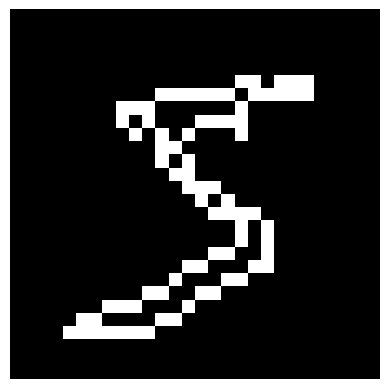

In [ ]:
image = x_train[0]
ret, thresh = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)
contour, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
boundary = max(contour, key=len).reshape(-1,2)
contour_image = np.zeros_like(image, dtype=np.uint8)
for p in boundary:
    contour_image[p[1]][p[0]] = 255
plt.imshow(contour_image, cmap='gray')
plt.axis(False)
plt.show()

In [ ]:
X = []
for image in X_images:
    chain_code = extract_chain_code_features(image)
    X.append(chain_code)

In [ ]:
max_length = max(map(len, X))
extracted_features = []
for chain in X:
    chain_code = chain + [0] * (max_length - len(chain))
    extracted_features.append(chain_code)

In [ ]:
X_chain_code = np.array(extracted_features)
Y = np.array(Y)
# X_train, X_test, y_train, y_test = train_test_split(extracted_features, Y, test_size=0.3, random_state=1234)

######################################

#Centroid

In [ ]:
(X_train, Y_train) , (X_test, Y_test) = datasets.mnist.load_data()

In [ ]:
X = np.concatenate((X_train,X_test))/255
y = np.concatenate((Y_train,Y_test))
X.shape, y.shape

((70000, 28, 28), (70000,))

# Indexing

In [ ]:
# get index
def getXF(img_):
  img = img_.copy()
  for i in range(img.shape[0]):
    img[i,:] = i
  return img

In [ ]:
def getYF(img_):
  img = img_.copy()
  for i in range(img.shape[1]):
    img[:,i] = i
  return img

#Visualizing Slicing

In [ ]:
def findBLocks(img,dim1 = 3,dim2 =3):
  data =[]

  for i in range(0,img.shape[0],dim1):
    for j in range(0, img.shape[1], dim2):
      block =img[i : i + dim1 ,j : j + dim2]
      idX = getXF(block)
      idY = getYF(block)
      mul1 = block * idX
      mul2 = block * idY
      X_bar = (mul1).sum() / (1e-9+ block.sum())
      Y_bar = (mul2).sum() / (1e-9+ block.sum())
      data.append(X_bar)
      data.append(Y_bar)
  return data

In [ ]:
X_controid = [findBLocks(i,3,3) for i in X]

In [ ]:
X_controid = np.array(X_controid)

In [ ]:
X_controid.shape

(70000, 200)

#Visualizaton

In [ ]:
def SliceImg(img, dim1,dim2):

  fig , ax = plt.subplots(int(np.ceil(28/dim1)),int(np.ceil(28/dim2)),figsize=(5,5))

  for i in range(0,img.shape[0],dim1):
    for j in range(0, img.shape[1], dim2):
      ax[i//dim1,j//dim2].imshow(img[i : i + dim1 ,j : j + dim2] ,cmap='gray')
      ax[i//dim1,j//dim2].axis("off")

  fig.tight_layout()
  fig.show()

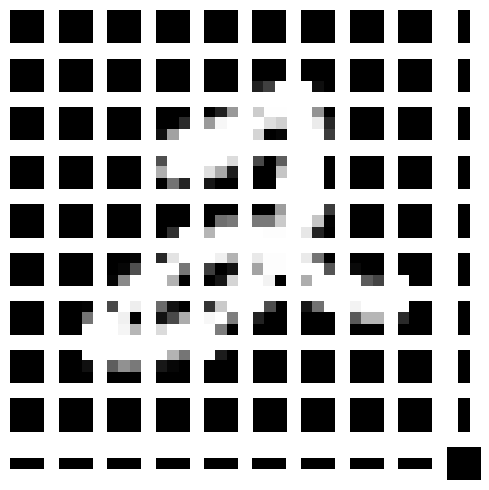

In [ ]:
SliceImg(X_train[5],3,3)

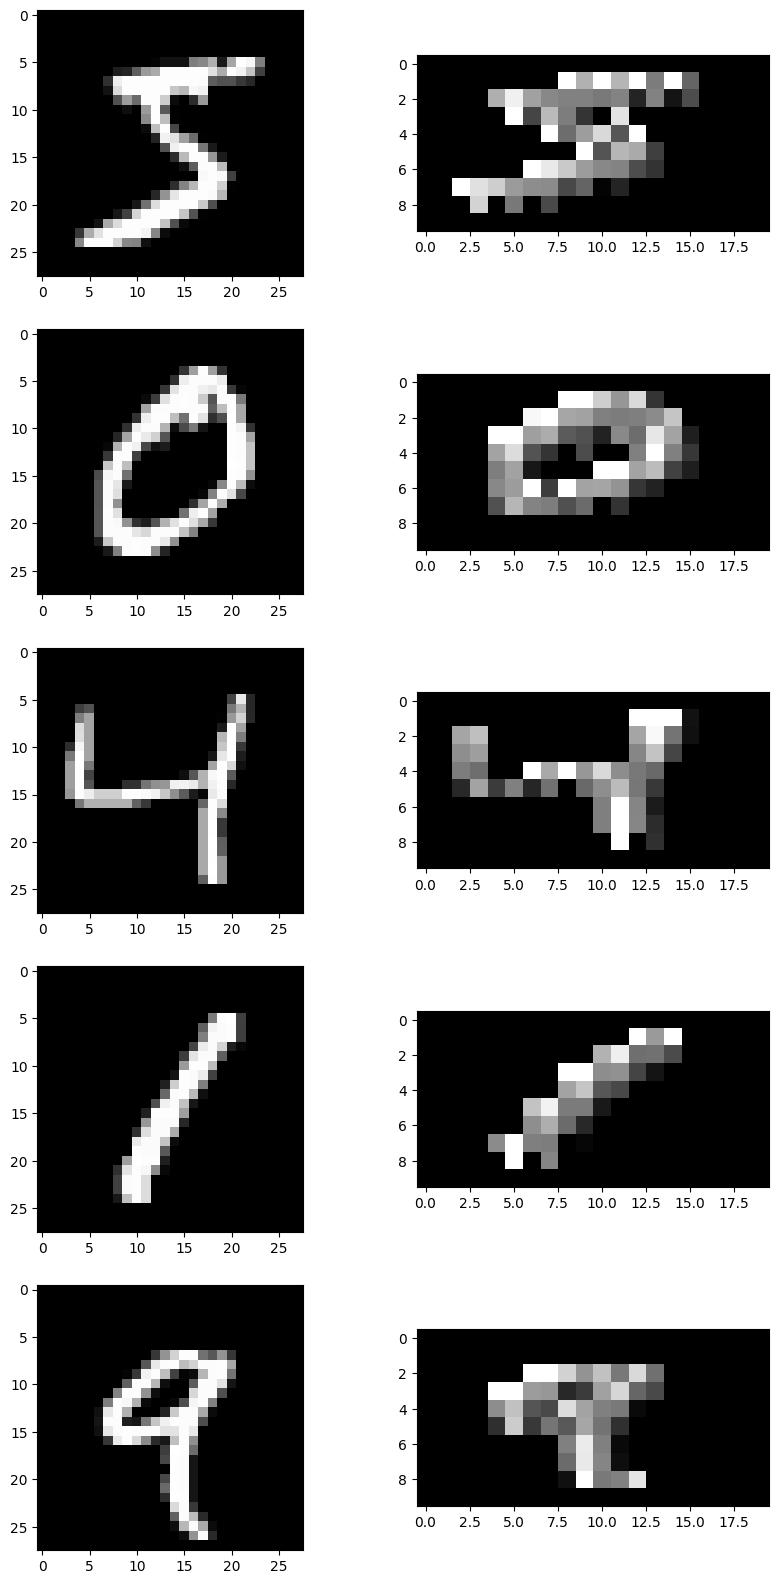

In [ ]:
import matplotlib.pyplot as plt
x_new = X_controid.reshape(-1,10,20)
fig,ax = plt.subplots(5,2,figsize=(10,20))

for i in range(5):
  ax[i,0].imshow(X_train[i],cmap='gray')
  ax[i,1].imshow(x_new[i],cmap='gray')


#K-mean

In [ ]:

k=10
def distance(vec1,vec2):
  return np.sqrt(np.sum((vec1-vec2)**2))

def chooseCentroids(X,y,clusters=10):
  init= []
  for i in range(clusters):
    av = np.mean( X[y==i],axis = 0)
    init.append(av)
  # idx = np.random.choice(X.shape[0],clusters,replace=False)
  return np.array(init)

def updateCentroids(X,pred):
  # print(X.mean(axis=0).shape)
  centroids= np.zeros(shape=(k,X.shape[1]))
  # print(centroids.shape)
  for i in range(len(centroids)):
    # print(X[pred == i].mean(axis=0))
    centroids[i] = X[pred == i].mean(axis=0)

  return centroids



def Kmean(X,y,clusters=10,iter=10):
  centroids = chooseCentroids(X,y)
  pred=[]
  for _ in tqdm(range(iter)):
    pred=[]
    for j in X:
      dist = np.zeros(10)
      for i,c in enumerate(centroids):
        dist[i] = distance(c,j)
      min_= dist.argmin()
      pred.append(min_)
    pred=np.array(pred)
    centroids = updateCentroids(X,pred)
  return np.array(pred),centroids

def predict(centroids,X):
  pred=[]
  for j in X:
      dist = np.zeros(10)
      for i,c in enumerate(centroids):
        dist[i] = distance(c,j)
      min_= dist.argmin()
      pred.append(min_)

  return np.array(pred)

#kmean with chain code

In [ ]:

from sklearn.model_selection import train_test_split

X_train_chain_code, X_test_chain_code, y_train, y_test = train_test_split(X_chain_code, Y, test_size=0.2, random_state=42)


In [ ]:
chain_code_trainpred,centroids = Kmean(X_train_chain_code,y_train,clusters=10,iter=10)
chain_code_testpred = predict(centroids,X_test_chain_code)

  0%|          | 0/10 [00:00<?, ?it/s]

#Kmean with centroids

In [ ]:

from sklearn.model_selection import train_test_split

X_controid_train, X_controid_test, y_train, y_test = train_test_split(X_controid, Y, test_size=0.2, random_state=42)


In [ ]:
centroid_trainpred,centroids = Kmean(X_controid_train,y_train,clusters=10,iter=10)
centroid_testpred = predict(centroids,X_controid_test)

  0%|          | 0/10 [00:00<?, ?it/s]

#Comparing

In [ ]:
import pandas as pd
y_test_values = pd.DataFrame(y_test).value_counts()
chain_codes_values = pd.DataFrame(chain_code_testpred).value_counts()
centroids_values = pd.DataFrame(centroid_testpred).value_counts()

def chainCode_centroid(chain_codes_values, centroids_values, y_train_values):
  for i in range(len(y_train_values)):
    chain_differ = abs(y_train_values[i] - chain_codes_values[i])
    centroid_differ = abs(y_train_values[i] - centroids_values[i])
    print(f"For class {i}, True values: {y_train_values[i]}, chain code:{chain_codes_values[i]}, centroid:{centroids_values[i]} better algo:", "Centroid" if centroid_differ<chain_differ else "Chain Code")

chainCode_centroid(chain_codes_values, centroids_values, y_test_values)

For class 0, True values: 1343, chain code:2398, centroid:1172 better algo: Centroid
For class 1, True values: 1600, chain code:1818, centroid:1699 better algo: Centroid
For class 2, True values: 1380, chain code:945, centroid:1100 better algo: Centroid
For class 3, True values: 1433, chain code:856, centroid:1572 better algo: Centroid
For class 4, True values: 1295, chain code:1046, centroid:1368 better algo: Centroid
For class 5, True values: 1273, chain code:1408, centroid:1422 better algo: Chain Code
For class 6, True values: 1396, chain code:876, centroid:1082 better algo: Centroid
For class 7, True values: 1503, chain code:1857, centroid:1435 better algo: Centroid
For class 8, True values: 1357, chain code:1223, centroid:1616 better algo: Chain Code
For class 9, True values: 1420, chain code:1573, centroid:1534 better algo: Centroid


In [ ]:
y_test_values , chain_codes_values, centroids_values

(1    1600
 7    1503
 3    1433
 9    1420
 6    1396
 2    1380
 8    1357
 0    1343
 4    1295
 5    1273
 Name: count, dtype: int64,
 0    2398
 7    1857
 1    1818
 9    1573
 5    1408
 8    1223
 4    1046
 2     945
 6     876
 3     856
 Name: count, dtype: int64,
 1    1699
 8    1616
 3    1572
 9    1534
 7    1435
 5    1422
 4    1368
 0    1172
 2    1100
 6    1082
 Name: count, dtype: int64)